In [143]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')



import powerlaw
import community as community_louvain
from fa2 import ForceAtlas2

from pathlib import Path
from tqdm.autonotebook import tqdm

import nltk
from wordcloud import WordCloud

In [11]:
# Define the locations of the dataframes to be used in the analysis, ie. characters' names and relationships
tot_relationships_url = 'https://raw.githubusercontent.com/gpanagioto/projects_socialgraphs22/main/Project2/Relationships/total_relationships.csv'
characters_df_url = 'https://raw.githubusercontent.com/gpanagioto/projects_socialgraphs22/main/Project2/reduced_characters_df.csv'

# Load the dataframes
relationships_df = pd.read_csv(tot_relationships_url, index_col=0)
characters_df = pd.read_csv(characters_df_url)

In [49]:
mask = relationships_df.source.isin(characters_df.name.to_list()) & relationships_df.target.isin(characters_df.name.to_list())
relationships_df = relationships_df[mask]

In [50]:
G = nx.from_pandas_edgelist(relationships_df,
                           source='source',
                           target='target',
                           edge_attr='weight',
                           create_using=nx.Graph())

In [51]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 549
Number of edges: 6325


### Greatest connected component

In [15]:
Gcc = list( nx.connected_components(G))
Gcc = sorted(Gcc, key=len, reverse=True)
print(f"Number of connected components: {len(Gcc)}")

Number of connected components: 1


In [16]:
for i,  comp in enumerate(Gcc):
    print(f"Component {i}: {len(comp)}")   

Component 0: 549


Since there is only one component by using the reduced characters relationships, the initial network is kept.

In [17]:
print(f'The greatest connected component contains {G.number_of_nodes()} nodes.')
print(f'The greatest connected component contains {G.number_of_edges()} edges.')

The greatest connected component contains 549 nodes.
The greatest connected component contains 6325 edges.


### Degree distribution

In [18]:
degrees_dist = np.array([ degree for (node, degree) in G.degree() ])

bins  = np.arange(degrees_dist.min(), degrees_dist.max()+1, 1)
hist, edges = np.histogram( degrees_dist, bins=bins )

In [19]:
N = G.number_of_nodes()
k_avg = degrees_dist.mean() # average degree

# probability p for E-R network
p = k_avg/(N-1)

# Generate directed ER network of same size and p 
G_er = nx.erdos_renyi_graph(n=N, p=p)

# Degree distribution for ER network
degrees_dist_er = np.array([deg for (node, deg) in G_er.degree()])

# Histogram for ER network
hist_er, edges_er = np.histogram(degrees_dist_er, bins=np.arange( degrees_dist_er.min(), degrees_dist_er.max()+1,1 ))

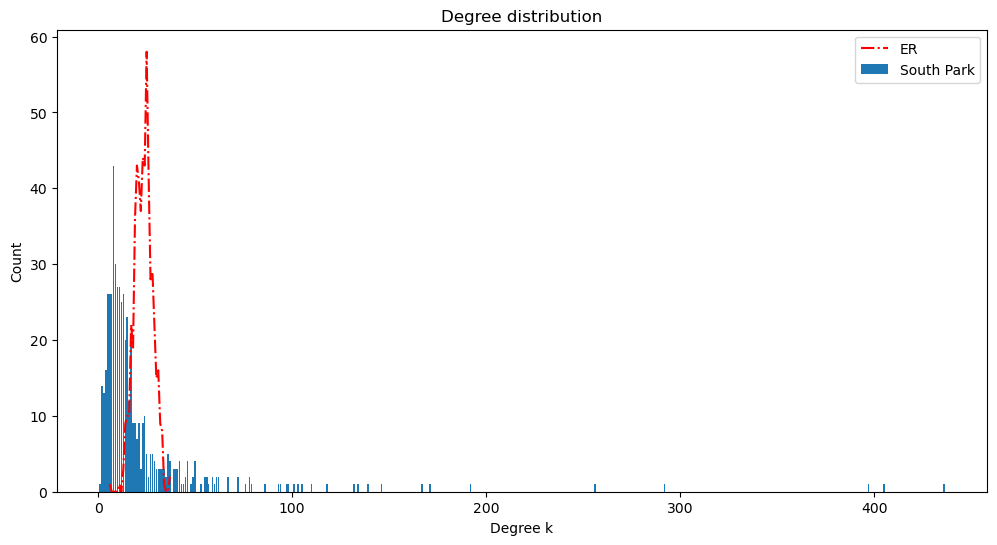

In [20]:
fig = plt.figure(figsize=(12,6))

plt.bar(edges[:-1], hist, width=0.8, label='South Park' )
plt.plot(edges_er[:-1], hist_er, 'r-.', label='ER')
plt.xlabel('Degree k')
plt.ylabel('Count')
plt.title('Degree distribution')


plt.legend()
plt.show()

Comparing the ER network with the South Park network, we can see that the later is a real world network, since it allows for large degrees and also that the majority of degrees are smaller in value than the average degree.

To get a better sense of the regime the network is in, we can plot the degree distribution in logarithmic scale. We also use the `powerlaw` library to estimate the degree exponent.

In [21]:
power_law_fit = powerlaw.Fit(degrees_dist)

degree_exponent = power_law_fit.alpha
print(f"The degree exponent is estimated: {np.round(degree_exponent,4)}")

The degree exponent is estimated: 2.5569


Calculating best minimal value for power law fit
C:\Users\user\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


Since the estimated degree exponent  has value $\gamma$: $2 < \gamma < 3$, the network is in the [scale-free regime](http://networksciencebook.com/chapter/4#degree-exponent). Large hubs are expected to exist, which decreases the distances between the nodes and the [Ultra-Small World](http://networksciencebook.com/chapter/4#ultra-small) phenomenon is observed.

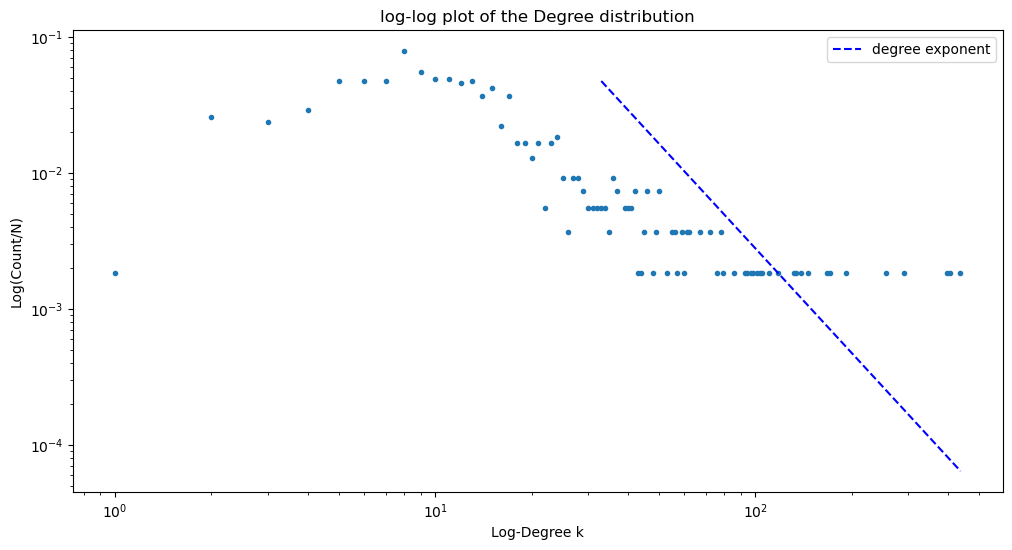

In [22]:
fig = plt.figure(figsize=(12,6))

plt.loglog(edges[:-1], hist/G.number_of_nodes(), '.' )
power_law_fit.power_law.plot_pdf(color= 'b',linestyle='--',label='degree exponent')

plt.xlabel('Log-Degree k')
plt.ylabel('Log(Count/N)')
plt.title('log-log plot of the Degree distribution')
plt.legend()

plt.show()

### Centrality measures to identify the most important characters
<a id='centrality_measures_total'></a>


Different centrality measures will be used to compare the importance of the top characters for each measure.

In [23]:
eigen_centr = nx.eigenvector_centrality(G)
closeness_centr = nx.closeness_centrality(G)
degree_centr = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)

In [24]:
data = {'name': list(betweenness.keys()),
        'betweenness':list(betweenness.values()),
        'eigenvector':list(eigen_centr.values()),
        'degree': list(degree_centr.values()),
        'closeness':list(closeness_centr.values()),
       }

centralities_df = pd.DataFrame.from_dict(data)

In [25]:
def plot_top_characters_centrality(centrality_dict, top_n):
    a = dict(sorted( centrality_dict.items(), key=lambda x: x[1], reverse=True )[:top_n])
    
    fig, ax = plt.subplots(1,1) 
    ax.bar(np.arange(len(list(a.values()))), list(a.values()))

    # Set number of ticks for x-axis
    ax.set_xticks( np.arange(len(list(a.keys()))) )
    # Set ticks labels for x-axis
    ax.set_xticklabels(list(a.keys()), rotation=60, fontsize=10)
    

In [127]:
# Top characters to show centralities
top_n = 10

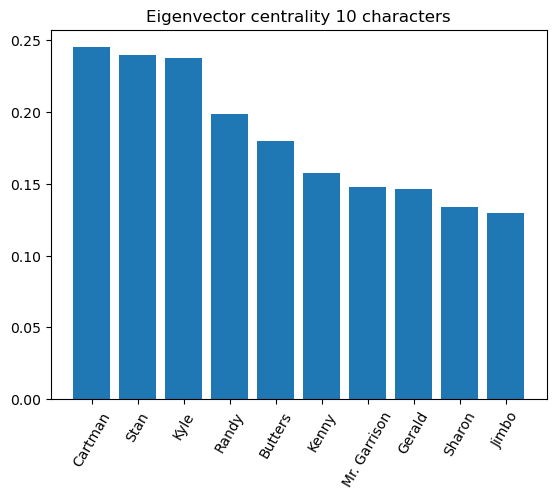

In [27]:
# eigen_centr = nx.eigenvector_centrality(G)

plot_top_characters_centrality(eigen_centr, top_n)
plt.title(f'Eigenvector centrality {top_n} characters')
plt.show()

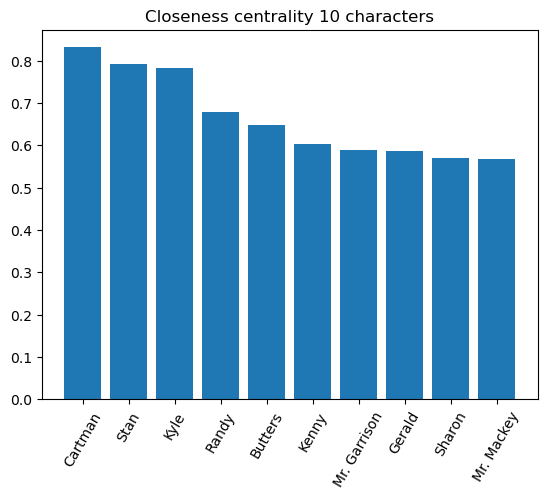

In [28]:
# closeness_centr = nx.closeness_centrality(G)

plot_top_characters_centrality(closeness_centr, top_n)
plt.title(f'Closeness centrality {top_n} characters')
plt.show()

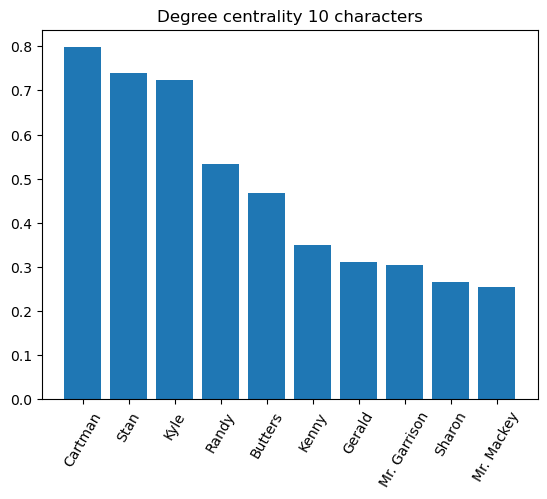

In [29]:
# degree_centr = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centr, 'degree_centr')

plot_top_characters_centrality(degree_centr, top_n)
plt.title(f'Degree centrality {top_n} characters')
plt.show()

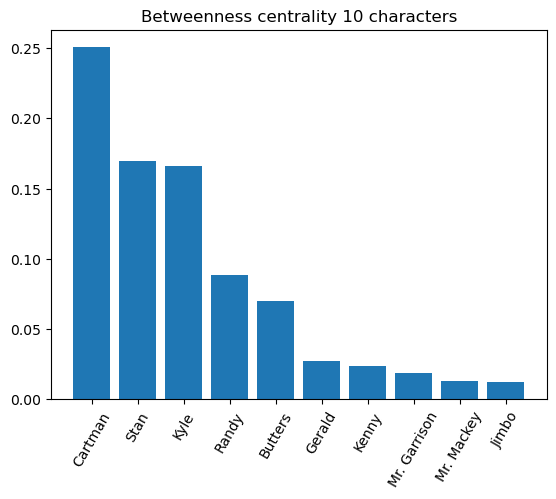

In [30]:
# betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness, 'betweenness')

plot_top_characters_centrality(betweenness, top_n)
plt.title(f'Betweenness centrality {top_n} characters')
plt.show()

The top characters in regards to the centrality measures are very similar. The results are very familiar for someone who follows the series. However, the largest difference  is observed in the case of betweenness centrality. The top 3 characters there have much higher centrality than the rest.

### Community detection  

The `community` library is used here and the Louvain algorithm is used to find the communities by maximizing the modularity.

In [31]:
partitions = community_louvain.best_partition(G, random_state=1337)
print(f"{len(set(list(partitions.values())))} communities detected, with modularity {np.round(community_louvain.modularity(partitions, G),4)}")

13 communities detected, with modularity 0.1996


Modularity has a value of $\approx 0.2$, leading to the conclusion that the partitioning is [Suboptimal](http://networksciencebook.com/chapter/9#modularity). Not all the real communities are detected.

In addition, the community a character belongs to can be added as an attribute to the graph:

In [32]:
nx.set_node_attributes(G, partitions, 'community')

Create a dictionary that stores the communities as keys and the list of the characters it includes as values:

In [40]:
communities_dict = {i:[char for (char, comm) in partitions.items() if comm==i] for i in set(partitions.values())}

# Sort communities based on the number of members
communities_dict = dict( sorted( communities_dict.items(), key=lambda x: len(x[1]), reverse=True ) )

for community in list(communities_dict.keys()):
    print(f"Community {community} has {len(communities_dict[community])} members")

Community 1 has 155 members
Community 0 has 109 members
Community 2 has 59 members
Community 7 has 46 members
Community 5 has 39 members
Community 10 has 34 members
Community 9 has 28 members
Community 4 has 23 members
Community 8 has 23 members
Community 11 has 17 members
Community 12 has 10 members
Community 3 has 4 members
Community 6 has 2 members


In [41]:
# Keep the communities that have members higher than a certain percentile of the total members
percentile_to_keep = 25
perc = np.percentile(np.array([ len(x) for (comm,x) in communities_dict.items() ]), q=percentile_to_keep)

communities_dict_tmp = {}

for comm, members in communities_dict.items():
    if len(members) >= perc:
        communities_dict_tmp[comm] = members
        
communities_dict = communities_dict_tmp
del communities_dict_tmp

In [42]:
for community in list(communities_dict.keys()):
    print(f"Community {community} has {len(communities_dict[community])} members")

Community 1 has 155 members
Community 0 has 109 members
Community 2 has 59 members
Community 7 has 46 members
Community 5 has 39 members
Community 10 has 34 members
Community 9 has 28 members
Community 4 has 23 members
Community 8 has 23 members
Community 11 has 17 members


We can also print some representative characters for each community:

In [43]:
communities_graphs_dict = {i:nx.subgraph(G, members) for i, members in communities_dict.items()}

n_repr = 7 # number of members to print
for community, members in communities_dict.items():
    comm_graph = communities_graphs_dict[community]
    top_deg_chars = {node: deg for node, deg in comm_graph.degree }
    top_deg_chars = list(dict(sorted( top_deg_chars.items(), key=lambda x: x[1], reverse=True )[:n_repr]).keys())
    print(f"Community {community}: {top_deg_chars}")

Community 1: ['Randy', 'Gerald', 'Sharon', 'Stephen', 'Jimbo', 'Sheila', 'Crowd']
Community 0: ['Cartman', 'Kyle', 'Stan', 'Butters', 'Kenny', 'Chef', 'Clyde']
Community 2: ['Wendy', 'Mr. Garrison', 'Mr. Mackey', 'Bebe', 'Principal Victoria', 'Mr. Slave', 'Red']
Community 7: ['Lollipop King', 'Beary Bear', 'Aslan', 'Pilot', 'DJ AM', 'Billy Mays', 'Patrick Swayze']
Community 5: ['Michael', 'Pete', 'Joe', 'Mike', 'Kevin', 'Nick', 'Tammy']
Community 10: ['Jimmy', 'Timmy', 'Announcer', 'Nathan', 'Mimsy', 'Agent', 'Elon Musk']
Community 9: ['Jesus', 'Satan', 'Chris', 'Seaman', 'Lao Tse', 'Buddha', 'Joseph Smith']
Community 4: ['Mark', 'Jenny', 'Dave', 'Mom', 'Gary', 'Dad', 'The kids']
Community 8: ['Rick', 'Terrance', 'Phillip', 'Scott', 'Stephen Abootman', 'Susan', 'Ugly Bob']
Community 11: ['Billy', 'Murphy', 'Professor Chaos', 'Yates', 'A voice', 'Coon', 'Mr. Foley']


### Assortativity   

With [assortativity](http://networksciencebook.com/chapter/7#introduction7) we can see if the hubs in the network tend to link to other hubs or prefer to link to low degree nodes. 

In [44]:
import networkx.algorithms as nx_alg

assort_coef = nx_alg.assortativity.degree_assortativity_coefficient(G)
print(f"Degree assortativity coefficient: {np.round(assort_coef,4)}")

Degree assortativity coefficient: -0.2781


Since the degree assortativity coefficient is negative , the network is  [disassortative](http://networksciencebook.com/chapter/7#measuring-degree), [also](https://en.wikipedia.org/wiki/Assortativity). Looks like the hubs avoid each other and prefer to link to lower degree nodes.  

We can repeat the experiment with the communities as attribute, asking the question: Do community members connect to each other or do they connect to members of different communities?

In [45]:
attr_assort_coef = nx_alg.assortativity.attribute_assortativity_coefficient(G, 'community')
print(f"Attribute (community) assortativity coefficient: {np.round(attr_assort_coef,4)}")

Attribute (community) assortativity coefficient: 0.171


In the case of communities, it seems the members of each community tend to connect to each other. This coefficient shows an assortative network. However, the value of the coefficinet is  positive, but not very close to 1.

### Visualization of the network  

With the detected communities, and using the edge attribute weight, we can plot a visualization of the network using the `ForceAtlas2` library.

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:04<00:00, 77.35it/s]


BarnesHut Approximation  took  8.01  seconds
Repulsion forces  took  48.78  seconds
Gravitational forces  took  0.28  seconds
Attraction forces  took  4.94  seconds
AdjustSpeedAndApplyForces step  took  1.41  seconds


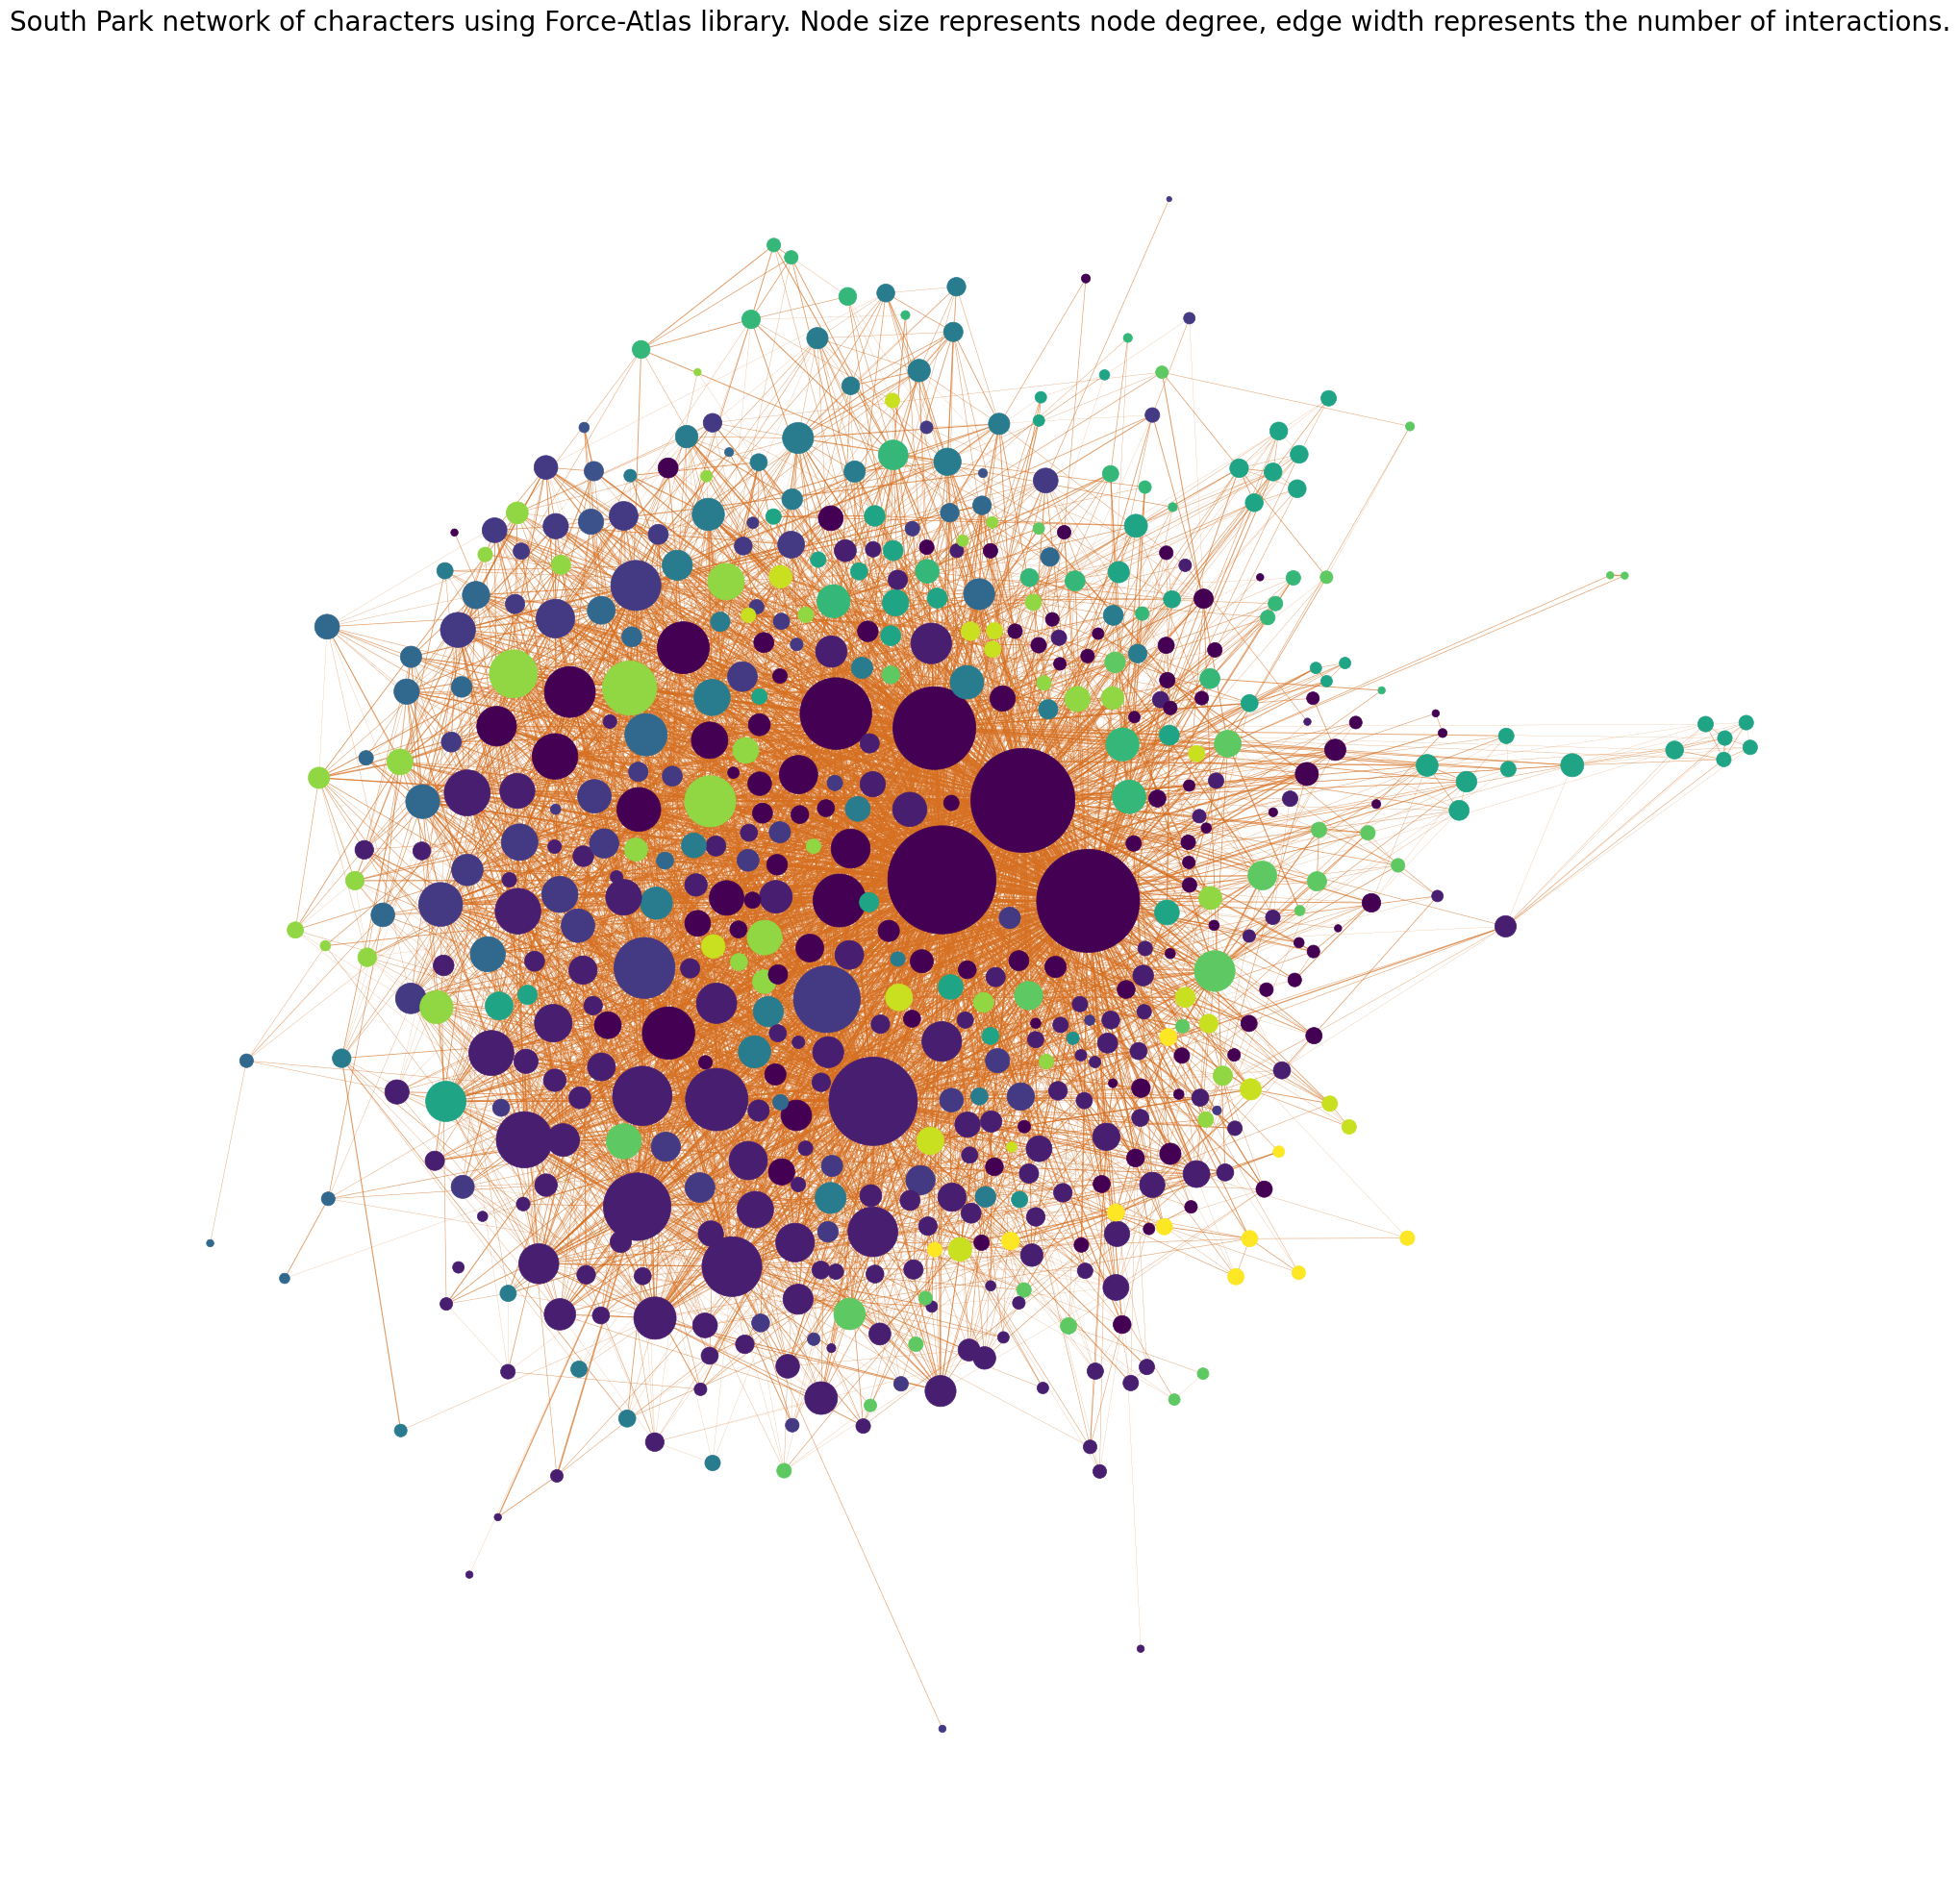

In [113]:
# Visulization of the network
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.1*1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=30.0,
                        strongGravityMode=False,
                        gravity=20.0*0.01,

                        # Log
                        verbose=True)

node_options = {
    # Setting node size based on degree
    'node_size' : [degree*15 for degree in degrees_dist],
    
    # Setting the node color based on the community it belongs to
    'node_color' :  list(partitions.values()),
    
    'alpha': 1
}



edges_options = {
    # Edge colors based on communities
    'width' : [ np.log(data["weight"])*0.21 for source, target, data in  G.edges(data=True)],
    'edge_color': '#d66f20', #'#71d6f0',
    'alpha': 0.7,
}



fig = plt.figure(figsize = [25, 25])
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5000)
nx.draw_networkx_nodes(G, positions, **node_options)
nx.draw_networkx_edges(G, positions, **edges_options)
plt.axis('off')

# # Indicating node colors
# y = 0.88 # This is the starting y position for the figure legend
# plt.figtext(1, y, 'Node colors:', size = 17, color = 'black')
# colots_node = ['green','red','purple']
# role_node = ['ally', 'enemy','boss']
# y -= 0.03
# for i in range(3):
#     plt.figtext(1, y, str(role_node[i]), size = 17, color = colots_node[i])
#     y -= 0.03

plt.title("South Park network of characters using Force-Atlas library. Node size represents node degree, edge width represents the number of interactions.", fontsize=20)
plt.show()

#### Centrality measures throughout the seasons  

We can investigate who the most important characters are through the seasons. This also shows how much each season is based on specific characters, or if there are fluctuations in 'popularity'.  

To do this, we must iniitally build networks for each season's interactions. They have been created, for the full and reduced character lists. Here, we will be working with the reduced character set, with the most important characters based on betweenness centrality. The procedure is identical to what has been done in the case of the interactions for the total number of seasons. However, now it will be compacted into functions for repeatability.  

In this case, the locally stored `.csv` files will be used, since it is automate the work with `pathlib` and `glob`.

In [52]:
relationships_path = Path.cwd() / 'Relationships'

In [64]:
def get_centralities_dict(relationships_dataframe, mask):
    '''
    Returns dictionary of centrality measures for the characters in the relationships dataframe,
    after applying a boolean mask.
    '''
    
    rel_df = relationships_dataframe[mask]
    G = nx.from_pandas_edgelist(relationships_dataframe,
                       source='source',
                       target='target',
                       edge_attr='weight',
                       create_using=nx.Graph())
    eigen_centr = nx.eigenvector_centrality(G)
    closeness_centr = nx.closeness_centrality(G)
    degree_centr = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G)
    
    
    centr_dict = {}
    for character in list(betweenness.keys()):
        centr_dict[character] = {'eigen_centr': eigen_centr[character],
                                 'closeness_centr': closeness_centr[character],
                                 'degree_centr':degree_centr[character],
                                 "betweenness": betweenness[character]
                                }
    return centr_dict

In [115]:
def distribute_centralities_to_dicts(centralities_dict):
    closeness_d = {}
    betweenness_d = {}
    degree_d = {}
    eigen_d = {}
    
    for key in list(centralities_dict.keys()):
        closeness_d[key] = centralities_dict[key]['closeness_centr']
        betweenness_d[key] = centralities_dict[key]['betweenness']
        degree_d[key] = centralities_dict[key]['degree_centr']
        eigen_d[key] = centralities_dict[key]['eigen_centr']
        
    # Sort the dictionaries
    closeness_d = dict( sorted( closeness_d.items(), key= lambda x: x[1], reverse=True ))
    betweenness_d = dict( sorted( betweenness_d.items(), key= lambda x: x[1], reverse=True ))
    degree_d = dict( sorted( degree_d.items(), key= lambda x: x[1], reverse=True ))
    eigen_d = dict( sorted( eigen_d.items(), key= lambda x: x[1], reverse=True ))
    
    return closeness_d, betweenness_d, degree_d, eigen_d

In [118]:
def get_top_n(centrality_dict_of_dicts, top_n=4):
    '''
    Return a dictionary of dictionaries, as its input.
    The first key is the season number, the second dictionary has the kvp: character: centrality measure
    '''
    out_dict = {}
    
    for key in list(centrality_dict_of_dicts.keys()):
        out_dict[key] = dict( sorted( centrality_dict_of_dicts[key].items(), key= lambda x: x[1], reverse=True )[:top_n] )
    
    return out_dict

In [119]:
season_closeness = {}
season_betweenness = {}
season_degree = {}
season_eigen = {}

season_nr = 1
for season in tqdm(relationships_path.glob('*.csv')):
    season_name = season.stem
    if season_name.split('_')[1]=='Season':
        season_rel_df = pd.read_csv(season, index_col=0)
        mask = season_rel_df.source.isin(characters_df.name.to_list()) & season_rel_df.target.isin(characters_df.name.to_list())
        
        # Get centrality measures for each season's relationship network
        centr_dict = get_centralities_dict(season_rel_df, mask = mask)
        
        # Get the top characters for each measure, add them to a dict
        season_closeness[season_nr], season_betweenness[season_nr],  season_degree[season_nr], season_eigen[season_nr] = distribute_centralities_to_dicts(centr_dict)
                
        season_nr += 1       

0it [00:00, ?it/s]

In [122]:
def plot_seasonal_centralities(season_centralities_dict, top_n=4, centrality_type='betweenness'):
    # Get the unique characters
    uniq_characters = []
    seasons = []
    for season in list(season_centralities_dict.keys()):
        seasons.append(season)
        uniq_characters += list(season_centralities_dict[season].keys())
        
    uniq_characters = list(set(uniq_characters))
    
    # Plot
    fig = plt.figure(figsize=(10,5))
    
    for character in uniq_characters:
        centr_meas = []
        for ses in seasons:
            try:
                centr_meas.append(season_centralities_dict[ses][character])
            except:
                centr_meas.append(None)
        
        plt.plot(seasons, centr_meas, '.-', label=character)
    
    plt.title(f"Top {top_n} characters regarding {centrality_type.title()} centrality per season")
    plt.ylabel(f"{centrality_type.title()} centrality value")
    plt.xlabel('Season')
    plt.xticks(seasons)
    plt.legend(bbox_to_anchor=(1.2, 0.5), loc="center right")
    
    plt.show()
    return  

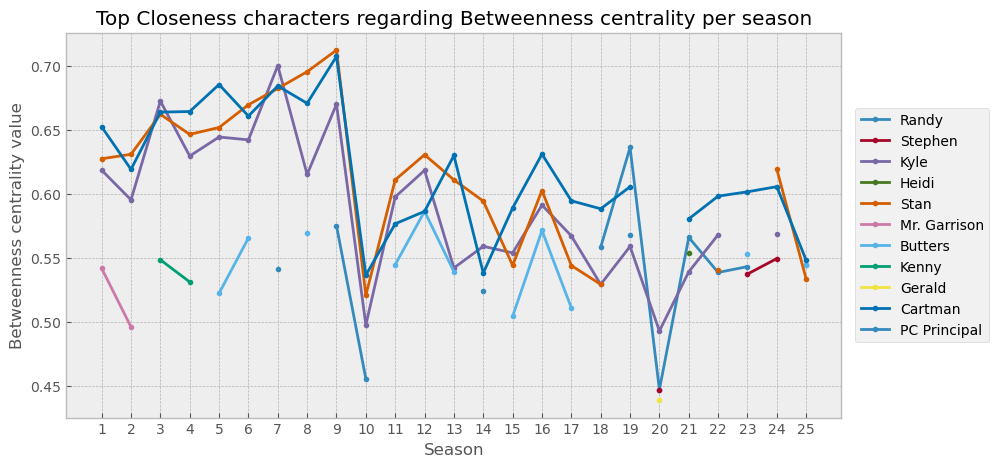

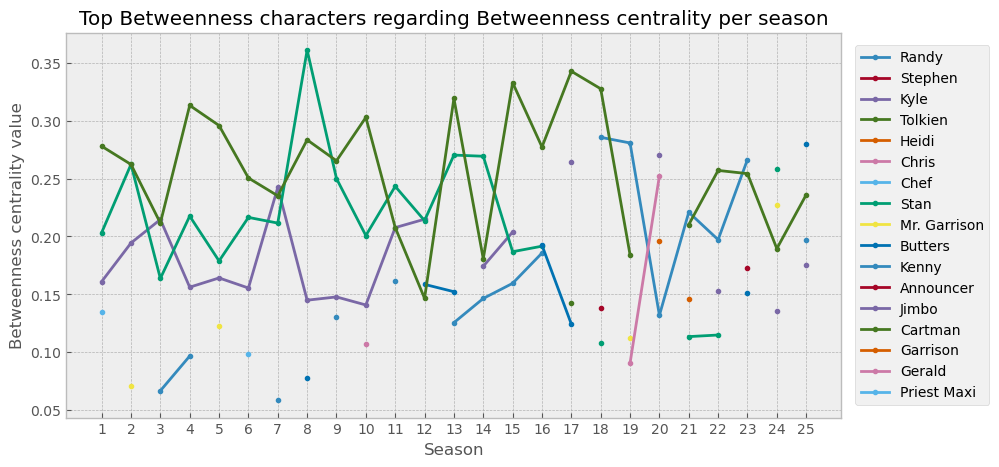

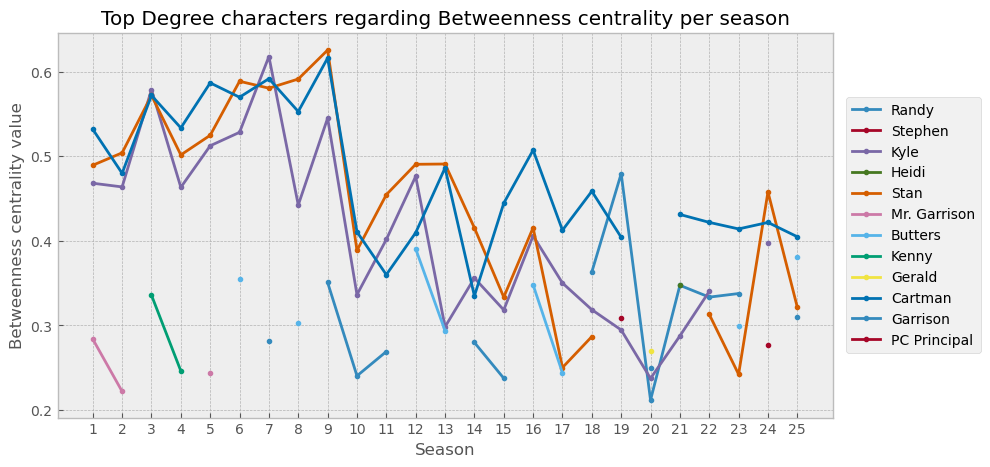

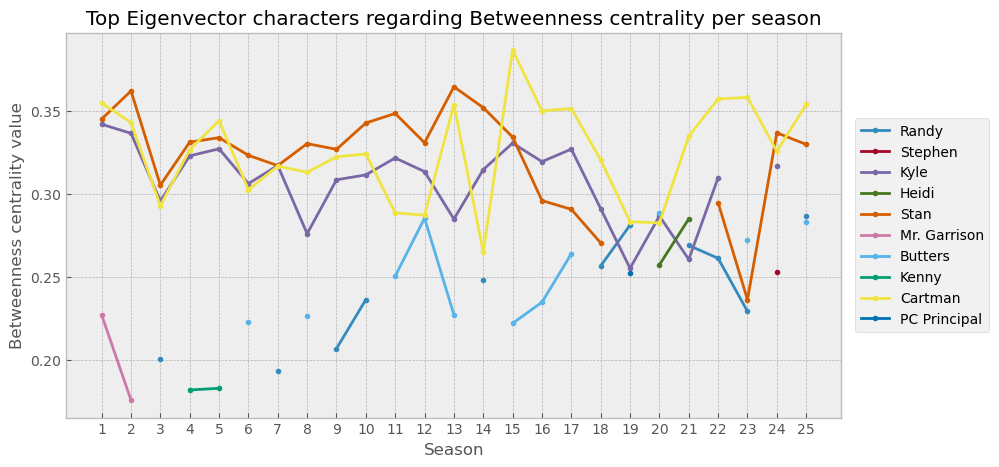

In [123]:
top_n_s = 4 # top characters per centrality

plot_seasonal_centralities(get_top_n(season_closeness, top_n_s), 'Closeness')
plot_seasonal_centralities(get_top_n(season_betweenness, top_n_s), 'Betweenness')
plot_seasonal_centralities(get_top_n(season_degree, top_n_s), 'Degree')
plot_seasonal_centralities(get_top_n(season_eigen, top_n_s), 'Eigenvector')

There can be seen some variations in all centrality measures across the seasons. Moreover, for the case of degree and closeness centralities, the case that the characters `Cartman`, `Stan` and `Kyle` are the top ones drops after around season 9. This could mean that the show starts utlizing also other characters. This might also be the case if the theme of the series shifts to also work with different topics.  

### TF-IDF, Wordclouds

As a first approach to processing text, we are going to explore the most frequently used words for the top 6 characters in terms of betweenness centrality as measured across the whole show, as shown in the [centrality measures section](#centrality_measures_total). These characters are : `Cartman`, `Stan`, `Kyle`, `Randy`, `Butters` and `Kenny`. Since `Mr. Garrison` is also a nice persona, he/she is also included. These will be visualized as wordclouds. Initially, the stopwords can be removed by means of ready dictionaries from `nltk`. However, TF-IDF can be used to only keep the important terms. It does not hurt to use the stopwords before calculating the TF-IDF score, since it will spped up the computation time, having fwer tokens to process.

The documents are going to be the cumulative text for each of the characters, acquired from each episode and season. 

### Sentiment analysis

In [146]:
# Setting the texts path
texts_path = Path.cwd() / 'Texts'

In [195]:
# Gather the tokenized text for each character
cartman_text = ''
kyle_text = ''
stan_text = ''
randy_text = ''
kenny_text = ''
butter_text = ''
mr_garrison_text = ''

characters = ['Cartman', 'Stan', 'Kyle', 'Randy', 'Butters', 'Kenny', 'Mr. Garrison']
characters_texts = [cartman_text, stan_text, kyle_text, randy_text, butter_text, kenny_text, mr_garrison_text]
characters_tokens = [ [],[],[],[],[],[],[] ]

In [196]:
# Avoid including punctuation
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# Stopwords list from nltk
stopwords = nltk.corpus.stopwords.words('english')

In [197]:
# Iterate through all episodes and add the text for each characters
for i, character in tqdm(enumerate(characters)):
    for file in texts_path.glob(f'**/{character}.txt'):
        with open(file.as_posix(), 'r', encoding='utf-8') as f:
            doc = f.read()
            characters_texts[i] += doc
            tokens = tokenizer.tokenize(doc)
            characters_tokens[i] += [token.lower() for token in tokens if token not in stopwords and len(token)>1]

0it [00:00, ?it/s]

In [198]:
nltk.FreqDist(characters_tokens[5]).most_common(15)

[('yeah', 125),
 ('what', 74),
 ('oh', 59),
 ('guys', 53),
 ('fuck', 52),
 ('hey', 47),
 ('no', 47),
 ('dude', 46),
 ('you', 42),
 ('uh', 36),
 ('know', 32),
 ('get', 29),
 ('woohoo', 26),
 ('huh', 26),
 ('okay', 25)]

'What\'s a dildo, Kenny? Dude, that kicks ass! Whoa, Cartman! Looks like you didn\'t get much sleep last night. Dude! Visitors! That wasn\'t a dream Cartman, those were visitors! Visitors are real. What\'s gonna be for lunch today, Chef? They took him on their ship. Dude, they did, huh? Aliens stuck stuff up your ass! Good morning, Miss Crabtree. Oh, don\'t worry about him. Yeah, whatever, ya fat bitch. I said I have a bad itch. Cartman, are those the same Visitors you saw? Well, we can\'t do anything for now, that fat bitch won\'t let us. Uh, I said that rabbits eat lettuce.  Okay, okay, let\'s ditch school and go find him. Dude! Dude! It\'s the alien anal probe. It\'s shooting fire from Cartman\'s rectum! How can you eat when you\'re farting fire?  Where? Shut up, fat ass! I don\'t even like her! I do not! Bleech!  Holy crap! It says she wants to meet me at Stark\'s Pond after school.  What? How do you know she has a cat? Uh, Chef? Chef. Chef!  \'\'\'\'\'CHEF!!!\'\'\'\'\' Visitors to